# OFA: Image Captioning with Transformers
In this notebook, we will show how to run the inference of OFA on image captioning with our support of OFA on Huggingface Transformers. 

In brief, the whole process is simple. After building the environment and cloning the related codes and checkpoints, what you need to do is just to provide an image with some simple preprocessing, build the model and generator (either Fairseq generator that we provide or HF native generator), and obtain the result.


In [1]:
!git clone --single-branch --branch feature/add_transformers https://github.com/OFA-Sys/OFA.git

fatal: destination path 'OFA' already exists and is not an empty directory.


In [2]:
!pip install OFA/transformers/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./OFA/transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3916779 sha256=138e20e484844dca6c973fa0c61ccf2beb48774c6b29221b724fcd57dc022045
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ztneo2m/wheels/20/01/92/4b280d748de8d14733cd3027f54a4fae2fcd95479148c48cf3
Successfully built transformers
  Attempting uninstal

In [3]:
!git lfs install
#!git clone https://huggingface.co/OFA-Sys/OFA-tiny
!git clone https://huggingface.co/OFA-Sys/OFA-huge

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
fatal: destination path 'OFA-huge' already exists and is not an empty directory.


In [4]:
from PIL import Image
from torchvision import transforms
from transformers import OFATokenizer, OFAModel
from transformers.models.ofa.generate import sequence_generator

In [5]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 256

In [6]:
patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [7]:
!ls
ckpt_dir='./OFA-huge'
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)

Dec15_JS-blog-Xmas-tree_Fotolia-Afanasia_feature.jpg	OFA-huge     test.jpg
Dec15_JS-blog-Xmas-tree_Fotolia-Afanasia_feature.jpg.1	OFA-tiny
OFA							sample_data
./OFA-huge
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [21]:
txt = " whats in the image, in detail?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
!wget https://www.vettimes.co.uk/app/uploads/2016/12/Dec15_JS-blog-Xmas-tree_Fotolia-Afanasia_feature.jpg -O ./test.jpg
!ls
img = Image.open('./test.jpg')
patch_img = patch_resize_transform(img).unsqueeze(0)

--2022-12-29 14:57:19--  https://www.vettimes.co.uk/app/uploads/2016/12/Dec15_JS-blog-Xmas-tree_Fotolia-Afanasia_feature.jpg
Resolving www.vettimes.co.uk (www.vettimes.co.uk)... 172.67.75.176, 104.26.15.73, 104.26.14.73, ...
Connecting to www.vettimes.co.uk (www.vettimes.co.uk)|172.67.75.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101797 (99K) [image/jpeg]
Saving to: ‘./test.jpg’

./test.jpg          100%[===================>]  99.41K  --.-KB/s    in 0.009s  

2022-12-29 14:57:19 (10.3 MB/s) - ‘./test.jpg’ saved [101797/101797]

Dec15_JS-blog-Xmas-tree_Fotolia-Afanasia_feature.jpg	OFA-huge     test.jpg
Dec15_JS-blog-Xmas-tree_Fotolia-Afanasia_feature.jpg.1	OFA-tiny
OFA							sample_data


In [9]:
model = OFAModel.from_pretrained(ckpt_dir, use_cache=False)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Choice of Generators
We find that using our provided generator can consistently achieve a better performance on the benchmark evaluation. Therefore, we first provide a demonstration of how to use this generator, and later the native one from Transformers. 

In [22]:
generator = sequence_generator.SequenceGenerator(
    tokenizer=tokenizer,
    beam_size=5,
    max_len_b=16,
    min_len=0,
    no_repeat_ngram_size=3,
)

In [23]:
import torch
data = {}
data["net_input"] = {"input_ids": inputs, 'patch_images': patch_img, 'patch_masks':torch.tensor([True])}

In [24]:
gen_output = generator.generate([model], data)
gen = [gen_output[i][0]["tokens"] for i in range(len(gen_output))]

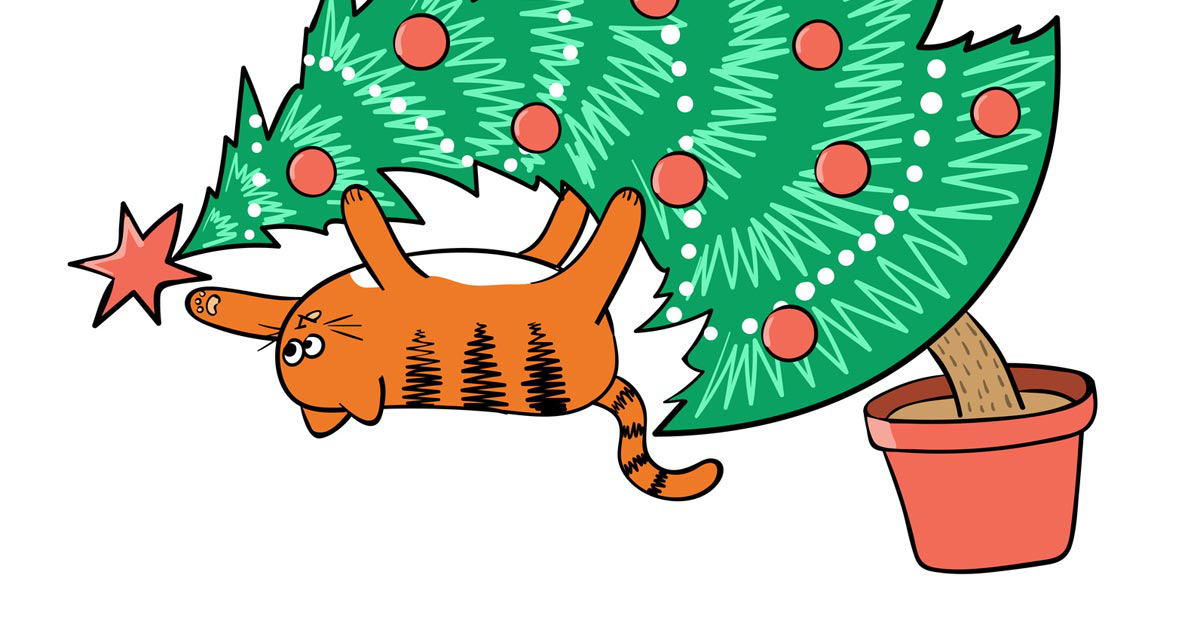

yes


In [25]:
display(img)
print(tokenizer.batch_decode(gen, skip_special_tokens=True)[0].strip())

In [14]:
gen = model.generate(inputs, patch_images=patch_img, num_beams=10, no_repeat_ngram_size=3)

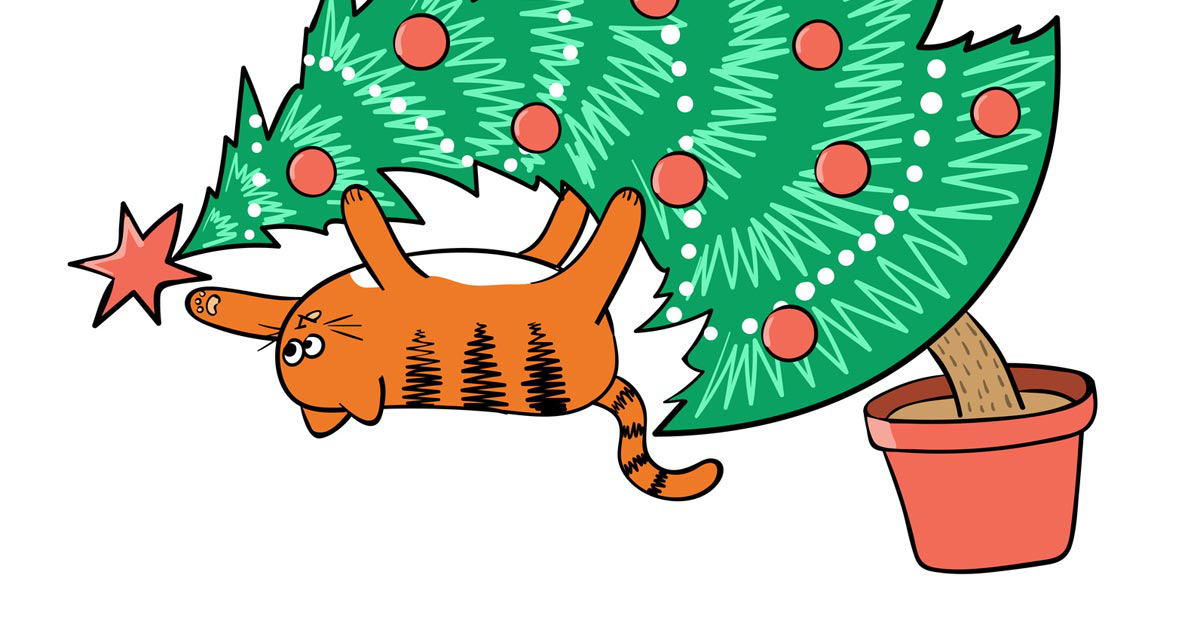

digital art selected for the #


In [15]:
display(img)
print(tokenizer.batch_decode(gen, skip_special_tokens=True)[0].strip())